# Imports

In [139]:
# Image processing libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Import of YOLO
from ultralytics import YOLO

# Character recognition
from pytesseract import pytesseract

# KMeans with fixed initial cluster centers
from sklearn.cluster import KMeans

import os
import time
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
import tensorflow_hub as hub

import torch
from torchvision import transforms, models
import torch.nn as nn
import pandas as pd

## Constants

In [140]:
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
# Declaring Constants
IMAGE_PATH = "img/Dataset/00020.jpg"  # Path to a test image
SAVED_MODEL_PATH =  "https://tfhub.dev/captain-pool/esrgan-tf2/1"
OUTPUT_DIR = "output/"
BRIGHTNESS_THRESHOLD = 100
SUPERRES_THRESHOLD = 1_000_000 # Represents the maximum image size to augment its resolution
TOP_K = 5 # Indicates how many predictions NN produce for each car
DEVICE = torch.device("cpu")

## Ausiliary functions

In [141]:
# Declare useful function (shortcuts)

def show_converted(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def show_gray(img):
    plt.imshow(img, cmap="gray")


## Enhancing functions (implemented by Simone Dao)

In [142]:
def lower_v_to_white(image,v_val):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # range definition in hsv scale
    lower_gray = np.array([0, 0, 0], dtype=np.uint8)
    upper_gray = np.array([180, 255, v_val], dtype=np.uint8) #change last value 40-150 (150 allows lighter gray letters)

    # create a mask in order to cut inner gray graduations
    mask = cv2.inRange(hsv_image, lower_gray, upper_gray)

    result_image = image.copy()
    # if the pixel is in the gray range, then paint it white
    result_image[mask == 0] = [255, 255, 255]

    return result_image

def threshold(image, interval):
  # convert the image in an array
  image = np.array(image)

  # approximate all the channels (bgr) of all the pixels
  for i in range(len(image)):
    for j in range(len(image[0])):
      value = image[i][j]
      for channel in range(3):
        # approximate to the closest multiple of interval
        scalar_value = int(value[channel] // interval) * interval
        value[channel] = scalar_value
      image[i][j] = value
  return image

def brightness(img):
    # returns brightness_average
    return cv2.mean(img)[0]

def increase_brightness(image):
    # if needed increases brightness level of the image
    brightness_average = cv2.mean(image)[0]
    if brightness_average < BRIGHTNESS_THRESHOLD:
        # the result is a multiplication to a factor that is slightly greater than 1
        image = cv2.addWeighted(image, 1.2, image, 0.8, 0)
    return image

def increase_contrast(image,alpha,beta):
    # split the three (bgr) channels
    canale_b, canale_g, canale_r = cv2.split(image)

    # linear transformation to all the channels
    nuovo_canale_b = np.clip(alpha * canale_b + beta, 0, 255).astype(np.uint8)
    nuovo_canale_g = np.clip(alpha * canale_g + beta, 0, 255).astype(np.uint8)
    nuovo_canale_r = np.clip(alpha * canale_r + beta, 0, 255).astype(np.uint8)

    # merge back all the channels
    image = cv2.merge([nuovo_canale_b, nuovo_canale_g, nuovo_canale_r])

    return image

def noise_reduction(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def increase_sharpness(image, mult): # better results with mult=~0.7, with 1.0 is usually too "strong"
    # kernel used in the sharpness transformation
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    kernel=kernel*mult

    # applying the kernel
    sharpened = cv2.filter2D(image, -1, kernel)

    return sharpened

def decrease_brightness(image, factor):  # factor usually works good with val=50
  image_temp = image.copy()
  immagine_grigia = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  # identifies pixels that are not black or white
  pixel_non_estremi = np.where((immagine_grigia >= 10) & (immagine_grigia < 240))
  
  # applies reduction to the previously identified pixels
  for y, x in zip(pixel_non_estremi[0], pixel_non_estremi[1]):
    pixel = image_temp[y, x]
    for c in range(3):  # iter on bgr
      pixel[c] = max(0, min(255, pixel[c] - factor))
    image_temp[y, x] = pixel
  return image_temp


## Functions for superesolution

In [143]:
def preprocess_image(img_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        img_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(img_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_tf_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)


def image_enhancer(image):
  if image.shape[0] < 64 | image.shape[1] < 64:
      return image

  n_pixels = image.shape[0] * image.shape[1]
  if n_pixels >= SUPERRES_THRESHOLD:
      return image
  
  enhanced_path = "output/standard.jpg"
  cv2.imwrite(enhanced_path, image)
  hr_image = preprocess_image(enhanced_path)
  
  model = hub.load(SAVED_MODEL_PATH)
  fake_image = model(hr_image)
  fake_image = tf.squeeze(fake_image)
  save_tf_image(tf.squeeze(fake_image), filename="output/Super Resolution")

  image = cv2.imread("output/Super Resolution.jpg")

  return image

### Creating car caption

In [144]:
def car_text(image, coordinates, car_names):
    img = Image.fromarray(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))
    # Load font
    percorso_font = "Montserrat-VariableFont_wght.ttf"

    # Aggiungi testo all'immagine
    draw = ImageDraw.Draw(img)

    # coordinate[x] = [x_topleft, y_topleft, x_botright, y_botright]
    for i in range(len(coordinates)):

        font_size = (coordinates[i][2] - coordinates[i][0]) // 30

        if font_size <= 20:
            thickness = 1
        else:
            thickness = 2

        if (coordinates[i][1] - font_size) <= 0:
            y = coordinates[i][1]
        else:
            y = coordinates[i][1] - font_size
        x = coordinates[i][0]

            
        font = ImageFont.truetype(percorso_font, size=font_size)
        # Put the text in upper left corner
        org = (x, y)

        draw.text(org, car_names[i], font=font, fill='red', stroke_width=thickness, stroke_fill='red')

    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


# Input image

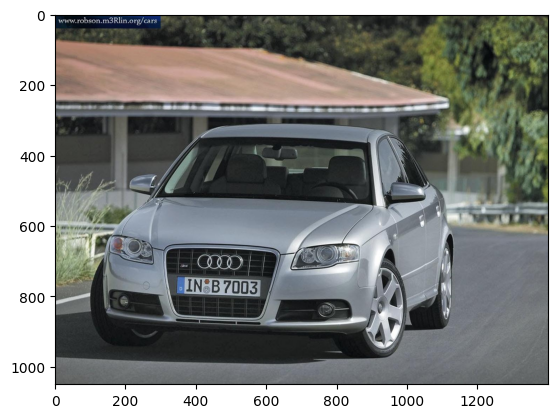

In [145]:
# Just show image

image = cv2.imread(IMAGE_PATH)
show_converted(image)

# Car detection and segmentation (implemented Filippo Grilli)

## Yolo: Detect cars in the image and draw the rectagules around them


0: 480x640 1 car, 1 truck, 183.4ms
Speed: 4.0ms preprocess, 183.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


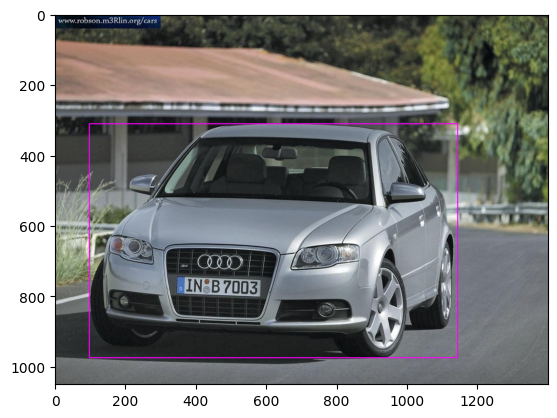

In [146]:
def yolo(img):
    # Load a model
    model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

    # Run model on the image
    results = model(img)

    # Take the boxes enveloping objects
    boxes = results[0].boxes
    
    # Definition of some variables that I will use
    matrix_coordinate = []
    names = model.names

    # Copy to evidence obtained results
    image_copy = img.copy()
    # Draw rectangles on the image,
    #  add the coordinate of theese rectangles to the matrix_coordinate
    filtered = [b for (b,c) in zip(boxes.xywh, boxes.cls) if names[int(c)] in ["car", "truck", "bus"]]
    todelete = []

    # Remove duplicates
    for i in range(len(filtered)):
        item1 = filtered[i]
        item1x_topleft,item1y_topleft,item1w1,item1h1 = item1
        item1x_botright = item1x_topleft + item1w1
        item1y_botright = item1y_topleft - item1h1
        for j in range(i+1,len(filtered)):
            if(i != j):
                item2 = filtered[j]
                item2x_topleft,item2y_topleft,item2w1,item2h1 = item2
                item2x_botright = item2x_topleft + item2w1
                item2y_botright = item2y_topleft - item2h1

                delta_pixels = 60

                if (abs(item1x_topleft - item2x_topleft) + abs(item1y_topleft - item2y_topleft) + abs(item1x_botright - item2x_botright) + abs(item1y_botright - item2y_botright)) < delta_pixels:
                    todelete.append(item1)
                    break
                    
    for i in range(len(todelete)):
        if todelete[i] in filtered:
            filtered.remove(todelete[i])  


    for coor in filtered:
        x,y,w,h = coor.numpy()
        x = int(x); y = int(y); w = int(w); h = int(h)
        _rettangolo = cv2.rectangle(image_copy,(x-w//2,y-h//2),(x+w//2,y+h//2),(255,0,255), 2)
        matrix_coordinate.append((x-w//2,y-h//2, x+w//2,y+h//2))


    # Returns a new image where cars are enveloped in rectangles
    #   with coordinate of each
    return (image_copy, matrix_coordinate)

# Cars detection
image_yoloed, coordinate = yolo(image)
show_converted(image_yoloed)

## Create cropped image leaving some border space

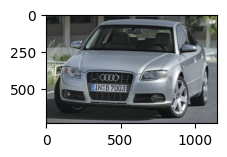

In [147]:
def crop(img, matrix_coordinate):
    # Definiton of array where the cropped images will be inserted
    cropped = []
    # Coordinates (wrt original image) of cropped parts
    coordinate_crop = {}
    # Array that stores the size of each margin
    margini = []


    # For each car relevated in the image we will save a new crop-image
    for i in range(len(matrix_coordinate)):
        # Coordinates of the car
        altezza = matrix_coordinate[i][1]
        base = matrix_coordinate[i][3]
        larghezza_sx = matrix_coordinate[i][0]
        larghezza_dx = matrix_coordinate[i][2]
        # Leave some margin around
        margine_y = (base - altezza) * 5 // 100
        margine_x = (larghezza_dx - larghezza_sx) * 5 // 100

        coordinate_crop[i] = {"altezza": altezza, "base":  base, "larghezza_sx": larghezza_sx, "larghezza_dx": larghezza_dx, "margine_x": margine_x, "margine_y": margine_y}

        # Check if margins are too large
        if altezza-margine_y < 0:
            margine_sx = altezza
        else:
            margine_sx = margine_y

        if base+margine_y >= img.shape[0]:
            margine_dx = img.shape[0]-base
        else:
            margine_dx = margine_y   

        if larghezza_sx-margine_x < 0:
            margine_sotto = larghezza_sx
        else:
            margine_sotto = margine_x  

        if larghezza_dx+margine_x >= img.shape[1]:
            margine_sopra = img.shape[1]-larghezza_dx
        else:
            margine_sopra = margine_x

        # Crop image
        cropped_image = img[max(0, altezza-margine_y):min(img.shape[0], base+margine_y), 
                            max(0,larghezza_sx-margine_x):min(img.shape[1], larghezza_dx+margine_x)]
    
        # Filter small images
        if (base - altezza) > 50 and (larghezza_dx-larghezza_sx) > 50:
            cropped.append(cropped_image)
            margini.append((margine_sopra, margine_sotto, margine_sx, margine_dx))
            
    return (cropped, margini, coordinate_crop)

# Crop cars
cropped, margini, coordinate_crop = crop(image, coordinate)
# Show results
for i in range(len(cropped)):
    plt.subplot(3, len(cropped)//3 + 1, i+1)
    show_converted(cropped[i])

In [148]:
# Save intermediate result in files
def save_cropped(cropped):    
    # Create the cropped images of the cars present in the input image
    for i in range(0, len(cropped)):
        # It is required a folder named "output" to save the fotos
        filename = "output/cropped_image" + str(i) + ".jpg"
        print(filename)
        cv2.imwrite(filename, cropped[i])
            
# save_cropped(cropped)

## Segmentation

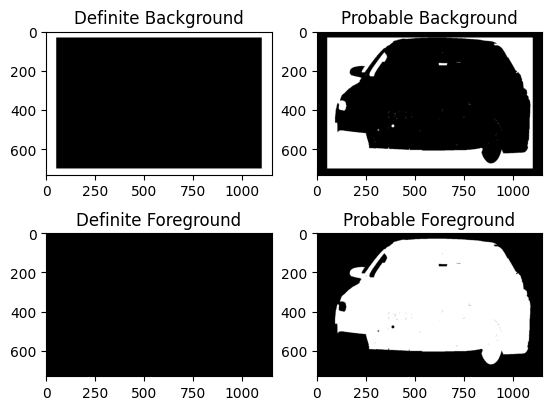

In [149]:
def segmentation(cropped, margini, show_results = False):
    # Stores the segmentation mask of each car
    masks = []

    # Enumerate each cropped image
    for (i, cropped_image) in enumerate(cropped):
        # Begin with empty mask
        mask = np.zeros(cropped_image.shape[:2], dtype="uint8")
        w,h = cropped_image.shape[:2]
        margine_sopra, margine_sotto, margine_sx, margine_dx = margini[i]
        # Rectangle without margins
        rect = (margine_sopra, margine_sx, h-margine_sotto-margine_sopra, w-margine_dx-margine_sx)
        
        # Allocate memory for two arrays that the GrabCut algorithm INTERNALLY
        #  uses when segmenting the foreground from the background
        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")

        # apply GrabCut using the bounding box segmentation method
        (mask, bgModel, fgModel) = cv2.grabCut(cropped_image, mask, rect, bgModel,
        fgModel, iterCount=3, mode=cv2.GC_INIT_WITH_RECT)

        # the output mask has for possible output values, marking each pixel
        # in the mask as (1) definite background, (2) definite foreground,
        # (3) probable background, and (4) probable foreground
        values = (
            ("Definite Background", cv2.GC_BGD),
            ("Probable Background", cv2.GC_PR_BGD),
            ("Definite Foreground", cv2.GC_FGD),
            ("Probable Foreground", cv2.GC_PR_FGD),
        )

        # loop over the possible GrabCut mask values and display their values
        #  if requested
        if show_results: 
            j = 1
            for (name, value) in values:
                # construct a mask for the current value
                valueMask = (mask == value).astype("uint8") * 255
                # display the mask so we can visualize the results
                plt.subplot(2, 2, j)
                j += 1
                show_gray(valueMask)
                plt.title(name)
        
        # Get only the foreground
        mask[mask != cv2.GC_PR_FGD] = 0
        masks.append(mask)
    return masks

# Create mask for each cropped car
masks = segmentation(cropped, margini, True)

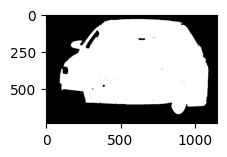

In [150]:
# Show segmentation results
for i in range(len(masks)):
    plt.subplot(3, len(masks)//3 + 1, i+1)
    show_gray(masks[i])

### Improve segmentation results

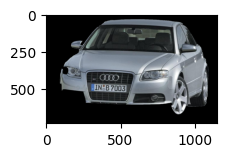

In [151]:
def fill_holes(cropped, masks):
    # Fill the binary_foreground from previous block
    segmented_array = []

    for (i, mask) in enumerate(masks):
        # Apply mask to the cropped image
        mask[mask != cv2.GC_PR_FGD] = 0

        # Fill holes with morphological CLOSE operation
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 12))
        filled = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Fill really big holes by filling contours
        contours, hier = cv2.findContours(filled, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            cv2.drawContours(filled, [cnt], 0, 255, cv2.FILLED)
            
        # Apply mask to extract car
        masked_image = cropped[i].copy()
        masked_image[filled == 0] = [0, 0, 0]

        # Save segmented version
        segmented = masked_image
        segmented_array.append(segmented)
    return segmented_array

# Use masks to extract segmented cars
segments = fill_holes(cropped, masks)
# Show results
for i in range(len(segments)):
    plt.subplot(3, len(segments)//3 + 1, i+1)
    show_converted(segments[i])

In [152]:
def segment_output(segmented_array, path):
  filenames = []
  for (i,seg) in enumerate(segmented_array):
    # It is needed a folder named "output" to save images
    filename = "output/seg_car" + str(i) + "_" + path
    filenames.append(filename)

    cv2.imwrite(filename, seg)
  return filenames

# Save the results of segmentation phase in files
#segments_files = segment_output(segments, IMAGE_PATH)

## All-in-one block

In [153]:
# Function to perform the entire segmentation phase (without intermediate results)
def all_segmentation(img):
    _image_yoloed, coordinate = yolo(img)
    #image_named = write_text(image_yoloed, coordinate)
    cropped, margini, coordinate_crop = crop(img, coordinate)
    #save_cropped(cropped)
    masks = segmentation(cropped, margini, False)
    segments = fill_holes(cropped, masks)
    return (segments, coordinate)

# all_segmentation(IMAGE_PATH)

# Extraction of plate information and model recognition (implemented by Petr Sabel)

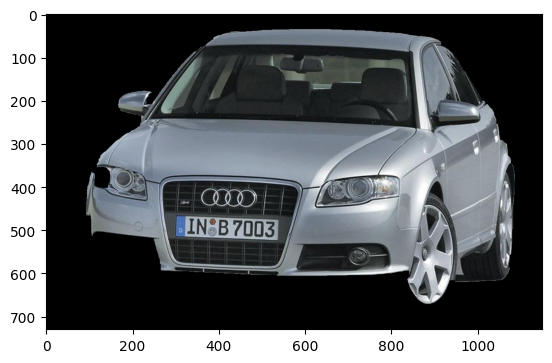

In [154]:
# Get segmented image

cropped_image = segments[0]
show_converted(cropped_image)

## Detect plate using simple threshold

Image was reduced 4 times


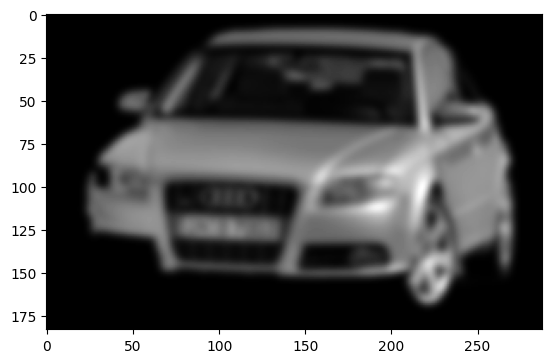

In [155]:
# Simple threshold after Gaussian
def gray_gaussian(img, d=6):
    # Before use Gaussian pyramid, need to reduce its size
    reduced = img.copy()
    factor = 0  # I want to obtain image around 100x200
    while reduced.shape[0] > 150 and reduced.shape[1] > 300:
        factor += 1
        reduced = cv2.pyrDown(reduced)

    dark = decrease_brightness(reduced, 25)

    gaussian = cv2.GaussianBlur(dark, (2*d+1, 2*d+1), -1)
    # Gaussian remove characters from plate
    return (cv2.cvtColor(gaussian, cv2.COLOR_BGR2GRAY), 2**factor)

gray, factor = gray_gaussian(cropped_image)
print(f"Image was reduced {factor} times")
show_gray(gray)

Threshold was set to 85.0


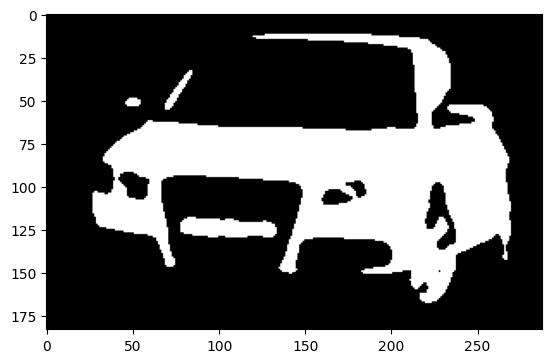

In [156]:
def white_thresh(img):
    # Use OTSU to automatically determine the threshold value (based on histogram)
    thresh, _ = cv2.threshold(img, 111, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh = thresh * 14 // 10
    print(f"Threshold was set to {thresh}")

    _, simple_thresh = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)

    return simple_thresh

# Transform image in binary one and find contours
threshed = white_thresh(gray)
contours, _ = cv2.findContours(threshed, 1, 2)
show_gray(threshed)

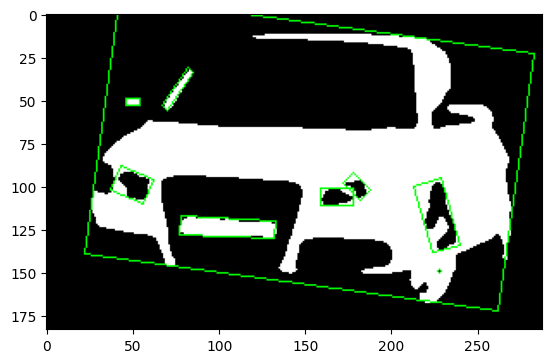

In [157]:
# Show contours
def show_rectangles(img, contours):
    tmp = img.copy()
    # Try to find min rect contours
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(tmp, [box], 0, (0, 255, 0), 1)
    show_converted(tmp)

show_rectangles(cv2.cvtColor(threshed, cv2.COLOR_GRAY2BGR), contours)

Res = [312 472 224  48] with 4 times


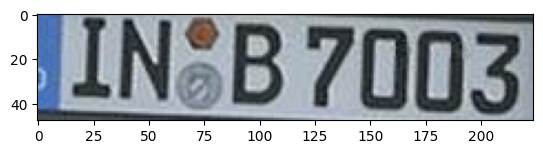

In [158]:
# Find plate rectangular (rectangular with most % of white pixels)

def find_plate_cnt(img, contours, factor):
    rects = {}
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        bounding = cv2.boundingRect(contour)
        (x,y), (w,h),  _ = rect
        rects[(x,y,w,h)] = (contour * factor, bounding) 
        
    # Function to determine the proportion of white pixels
    def count_white(item):
        cnt = item[1][0]
        # Empty mask
        mask = np.zeros(img.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [cnt], 0, 255, cv2.FILLED)

        # Compute white pixels ratio
        rect = cv2.minAreaRect(cnt)
        (_, _), (w, h), _angle = rect
        return mask.sum()//(w*h)

    # Remove rectangles too small ang large rectangles
    filtered = list(filter(lambda i: (i[0][2] > 5 and i[0][3] > 5 and i[0][2] < 150 and i[0][3] < 50), rects.items()))
    
    # Rectangles should be horizontal
    filtered = list(filter(lambda i: i[0][2] >= i[0][3] * 2, filtered))
    
    # Should not be too high
    filtered = list(filter(lambda i: i[1][1][1] > img.shape[0]//3, filtered))
    # NOTE: the minAreaRect has strange coordinates
    
    res = sorted(filtered, key = count_white, reverse=True)[0][1]
    res = (np.array(res[1]) * factor, res[0])
    print(f"Res = {res[0]} with {factor} times")
    
    return res

plate_coor, plate_cnt = find_plate_cnt(threshed, contours, factor)

# Show plate
x,y,w,h = plate_coor
plate = cropped_image[y:y+h, x:x+w]
plate_coor = (x, y, w, h)
show_converted(plate)

### Remove pixel external to plate contour

Saved as output/Super Resolution.jpg


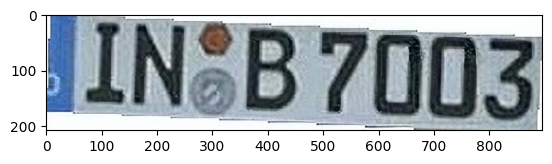

In [159]:
def remove_external_pixels(img, contour):
    # Get rotated plate from image
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    rect = cv2.boundingRect(box)
    
    width, height = img.shape[:2]
    plate_mask = np.zeros((width, height), dtype='uint8')
    cv2.drawContours(plate_mask, [box], 0, 255, cv2.FILLED)

    rotated_plate = img.copy()
    rotated_plate[plate_mask == 0] = (255, 255, 255)
    x, y, w, h = rect
    return rotated_plate[y: y+h, x: x+w]

# Show plate contour
masked_plate = remove_external_pixels(cropped_image, plate_cnt)
masked_plate = image_enhancer(masked_plate)
show_converted(masked_plate)

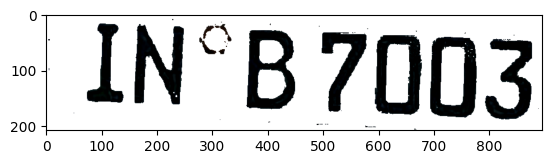

In [160]:
# Remove distracting colors

dark_plate = decrease_brightness(masked_plate, 50)
clean_plate = lower_v_to_white(dark_plate, 40)
show_converted(clean_plate)

### Try different image manipulations

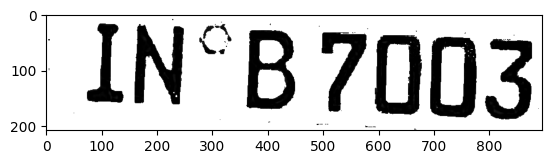

In [161]:
# Show grayscale version of the plate

plate_gray = cv2.cvtColor(clean_plate, cv2.COLOR_BGR2GRAY)
plt.imshow(plate_gray, cmap="gray")

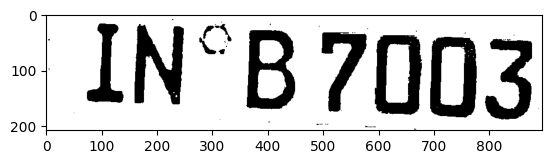

In [162]:
# Threshold the plate image to obtain a readable binary image (with OTSU)
_, threshed = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

show_gray(threshed)

### Try with rotation

Auto-computed angle is 0


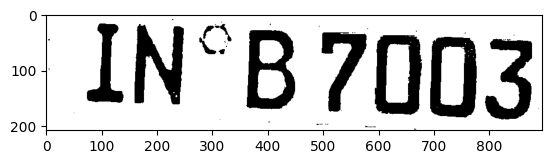

In [163]:
# Rotate function
def rotate_image(img, angle):
    # Rotate image to deskew
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# Automatic rotation
def auto_rotate_image(img):
    coords = np.column_stack(np.where(img > 0))
    # Compute rotated bounding box
    (w,h), angle = cv2.minAreaRect(coords)[1:]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # If rectangle is vertical
    if w < h:
        angle = 90 - angle

    if abs(angle) > 40:
        # Just leave the image
        angle = 0

    print(f"Auto-computed angle is {angle}")
        
    # Rotate image to deskew
    return rotate_image(img, angle)

auto_rotated = auto_rotate_image(threshed)
show_gray(auto_rotated)

220.8628692626953 42.50156784057617
Precomputed angle is 2.6025619506835938


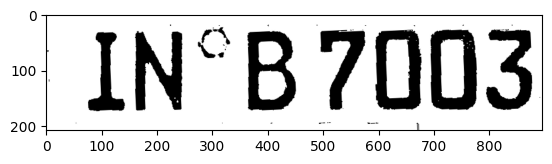

In [164]:
# Using precomputed angle
rect = cv2.minAreaRect(plate_cnt)
_, (w, h), angle = rect
print(w, h)
if w < h:
    angle = 90 - angle
print(f"Precomputed angle is {angle}")
rotated = rotate_image(threshed, angle)
show_converted(rotated)

## Character recognition

In [165]:
# Pytesseract
def text_recognition(img):
    # Defining paths to tesseract.exe 
    path_to_tesseract = r"/usr/bin/tesseract"
    pytesseract.tesseract_cmd = path_to_tesseract

    alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    options = "-c tessedit_char_whitelist={}".format(alphanumeric)
    # set the PSM mode
    options += " --psm {}".format(7) # treat image as a single text string

    return pytesseract.image_to_string(img, config=options)

texts = []

text = text_recognition(threshed)
print(f"Text from threshed = {text}")
texts.append(text)

text = text_recognition(auto_rotated)
print(f"Auto-Rotated text = {text}")
texts.append(text)

text = text_recognition(rotated)
print(f"Rotated text = {text}")
texts.append(text)

text = text_recognition(plate_gray)
print(f"Gray text = {text}")
texts.append(text)

text = text_recognition(plate)
print(f"Plate original text = {text}")
texts.append(text)

Text from threshed = INB7003

Auto-Rotated text = INB7003

Rotated text = INB7003

Gray text = INB7003

Plate original text = INSB7003



In [166]:
def major_prediction(texts):
    # Try to take majority for each letter (Average over texts)
    longest = sorted(texts, key=len, reverse=True)[0]

    text = ""
    for i in range(len(longest)):
        # Take letter from a text, but if text is not long enough take it from longest text 
        candidates = [ t[i] if i < len(t) else longest[i] for t in texts ]
        # For each unique item in candidates, count its frequence and take the letter with maximum one
        major = max(set(candidates), key = candidates.count)
        text += major

    text = text.strip()
    return text

text = major_prediction(texts)
print(f"Most probable text is '{text}'")

Most probable text is 'INB7003'


## Plate blurring

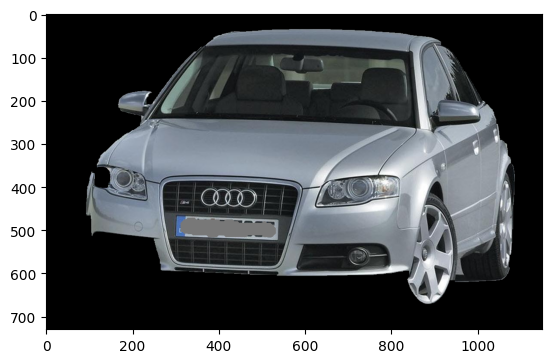

In [167]:
def blur_contour(img, cnt):
    # Blur the plate contour
    blurred_image = img.copy()
    cv2.drawContours(blurred_image, [cnt], 0, (120, 120, 120), cv2.FILLED)
    return blurred_image

blurred_image = blur_contour(cropped_image, plate_cnt.copy())
show_converted(blurred_image)

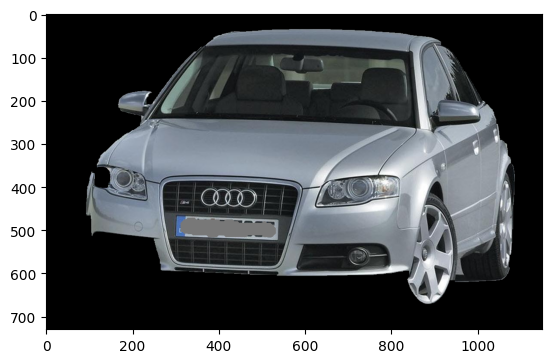

In [168]:
def blur_plate(img, coor):
    # Blur the entire plate rectangle using Gaussian
    x,y,w,h = coor
    # Include blue lines
    delta = (w // 3) // 2
    x -= delta
    w += 2*delta
    d = 20
    blurred = cv2.blur(img[y:y+h, x:x+w], (20,20))

    image_copy = img.copy()
    for j in range(x, min(x+w, blurred.shape[1])):
        for i in range(y, min(y+h, blurred.shape[0])):
            image_copy[i,j] = blurred[i-y,j-x]

    return image_copy

blurred_image = blur_plate(blurred_image, plate_coor)
show_converted(blurred_image)

## All-in-one block

Threshold was set to 85.0
Res = [312 472 224  48] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'INB7003'


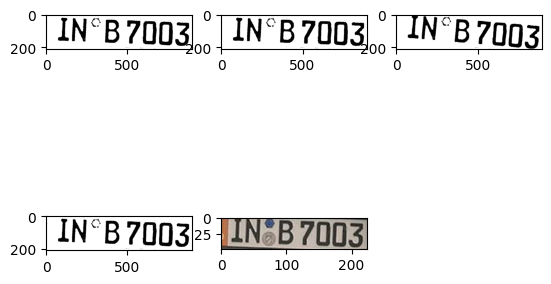

In [169]:
def plate_extraction(img):
    # Extract plate
    gray, factor = gray_gaussian(img)
    threshed1 = white_thresh(gray)
    contours, _ = cv2.findContours(threshed1, 1, 2)
    plate_coor, plate_cnt = find_plate_cnt(threshed1, contours, factor)
    x,y,w,h = plate_coor
    plate = img[y:y+h, x:x+w]
    # Generate plate versions
    masked_plate = remove_external_pixels(img, plate_cnt)
    masked_plate = image_enhancer(masked_plate)
    dark_plate = decrease_brightness(masked_plate, 50)
    clean_plate = lower_v_to_white(dark_plate, 40)
    plate_gray = cv2.cvtColor(clean_plate, cv2.COLOR_BGR2GRAY)
    _, plate_threshed = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    auto_rotated = auto_rotate_image(plate_threshed)
    
    rect = cv2.minAreaRect(plate_cnt)
    _, (w, h), angle = rect
    if w < h:
        angle = 90 - angle
    rotated = rotate_image(plate_threshed, -abs(angle))
    
    # Recognize plates
    plate_versions = [plate_threshed, auto_rotated, rotated, plate_gray, plate]
    texts = [text_recognition(p) for p in plate_versions]
    text = major_prediction(texts)
    print(f"Most probable text is '{text}'")
    # Blur plate
    blurred_image = blur_contour(img, plate_cnt)
    blurred_image = blur_plate(blurred_image, plate_coor)
    
    return (blurred_image, plate_coor, plate, text)
    
blurred, coor, extracted_plate, text = plate_extraction(cropped_image)

## Detection of the vehicle logo


[Fast logo detection paper](https://www.sciencedirect.com/science/article/pii/S004579061300061X)

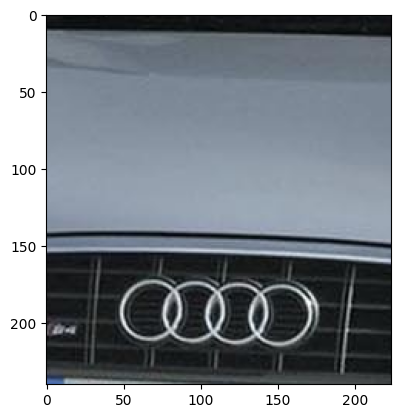

In [170]:
# First choose area above the plate

def crop_logo_zone(img, plate_coor):
    P = 5
    x,y,w,h = plate_coor
    y -= P*h
    y = max(0, y)
    h *= P; 
    return img[y:y+h, x:x+w]

above_plate = crop_logo_zone(cropped_image, coor)
above_gray = cv2.cvtColor(above_plate, cv2.COLOR_BGR2GRAY)
show_converted(above_plate)

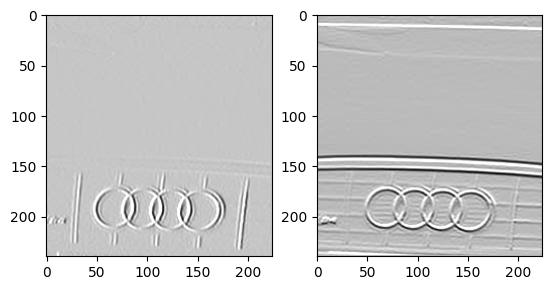

In [171]:
def calculate_gradients(img):
    scale = 1
    delta = 1
    ddepth = 3
    grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

    _, grad_x = cv2.threshold(grad_x, 255, 255, cv2.THRESH_TRUNC)
    _, grad_y = cv2.threshold(grad_y, 255, 255, cv2.THRESH_TRUNC)
    return (grad_x, grad_y)

grad_x, grad_y = calculate_gradients(above_gray)

plt.subplot(1, 2, 1)
show_gray(grad_x)
plt.subplot(1, 2, 2)
show_gray(grad_y)

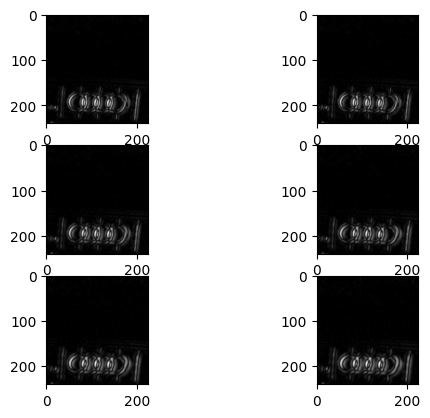

In [172]:
# Create saliency map using Itti algorithm

# Create Gaussian pyramids
def saliency(img):
    first = img.copy()
    height, width = first.shape[:2]
    pyramids = [first] # progressive Gaussian pyramids

    PYRADMIDS_NUM = 8

    for _ in range(PYRADMIDS_NUM):
        tmp = cv2.pyrDown(pyramids[-1])  # Downsampling image: gaussian filter, then remove even rows and columns
        pyramids.append(cv2.resize(tmp, dsize=(width,height), interpolation=cv2.INTER_LINEAR))

    # show_gray(pyramids[-1])

    # Compute differences between center and surroundings
    # surround_scale = center_scale + delta (delta in [3,4] and c in [2,3,4])
    saliency_maps = []
    for c in range(2,5):
        tmp = cv2.absdiff(pyramids[c], pyramids[c+3]) # |I_c - I_s|
        saliency_maps.append(tmp)

        tmp = cv2.absdiff(pyramids[c], pyramids[c+4])
        saliency_maps.append(tmp)
        
    return saliency_maps


h_maps = saliency(grad_x)
v_maps = saliency(grad_y)

for (i,s) in enumerate(h_maps):
    plt.subplot(3, len(h_maps)//3, i+1)
    show_gray(s)


In [173]:
# Try to combine maps into one

# Using max, instead of mean seems more accurate
Sh = np.max(h_maps, axis=0).astype("float32")
Sv = np.max(v_maps, axis=0).astype("float32")

print(Sh.max(), Sh.min(), Sh.shape, Sh.dtype)
print(Sv.max(), Sv.min(), Sv.shape)

197.0 0.0 (240, 224) float32
156.0 0.0 (240, 224)


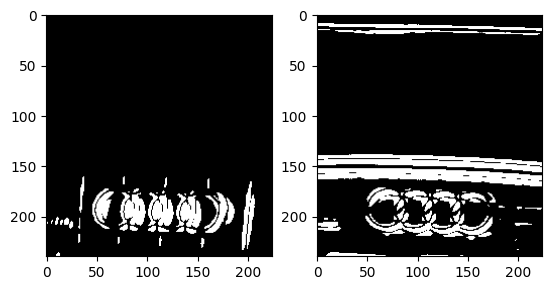

In [174]:
# K-means to transform map into binary image

def binary_kmeans(img, map):
    tmp = map.reshape((-1,1))
    # Select as starting clusters the first and the last samples
    # Maybe, in some case, horizontal and vertical image will have different first pixels,
    #    so clusters will be opposite
    clusters = np.array([[0], [tmp.shape[0]]], np.float64)
    km = KMeans(n_clusters=2, init=clusters, n_init=1).fit(tmp)
    labels = km.labels_

    labels = labels.reshape(map.shape)
    binary = img.copy()
    binary[labels == 0] = 0
    binary[labels != 0] = 255
    return binary

h_binary = binary_kmeans(grad_x, Sh)
v_binary = binary_kmeans(grad_y, Sv)

plt.subplot(1, 2, 1)
show_gray(h_binary)
plt.subplot(1, 2, 2)
show_gray(v_binary)

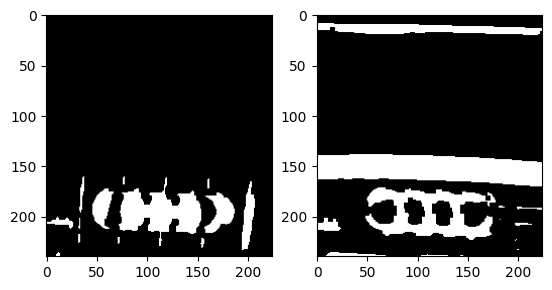

In [175]:
# Now I have to use morphology CLOSE operation
def morph_close(img, d = 3):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (d, d))
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

d = 5
h_closed = morph_close(h_binary, d)
v_closed = morph_close(v_binary, d)

plt.subplot(1, 2, 1)
show_gray(h_closed)
plt.subplot(1, 2, 2)
show_gray(v_closed)

0.290655248207056 0.5048312949608159


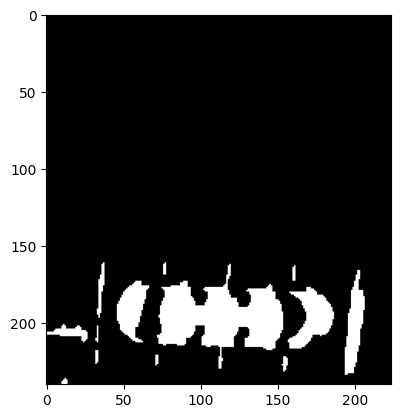

In [176]:
# Choose the image with less irrelevant information (and also less noise) from horizontal and vertical
def entropy(img):
    hist, _bin = np.histogram(img.ravel(), 256, [0,255])
    entropy = 0.
    for i in hist[hist != 0]:
        p = i/img.size
        entropy -= p * np.log(p)
    return entropy

h_entropy = entropy(h_closed)
v_entropy = entropy(v_closed)
print(h_entropy, v_entropy)

clear_image = h_closed if h_entropy < v_entropy else v_closed
show_gray(clear_image)

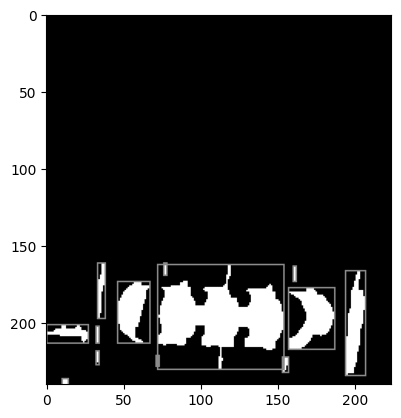

In [177]:
# Separate different regions
clear_image = clear_image.astype("uint8")
contours, _ = cv2.findContours(clear_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

def show_contours(img, contours):
    with_rectangles = img.copy()
    for contour in contours:
        # Select contours above a certain area
        # Store the coordinates of the bounding boxes
        [X, Y, W, H] = cv2.boundingRect(contour)

        # Draw bounding boxes in the image
        cv2.rectangle(with_rectangles, (X, Y), (X + W, Y + H), (140), 1)
    
    show_gray(with_rectangles)

show_contours(clear_image, contours)

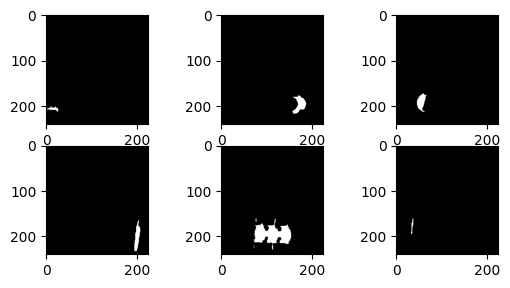

In [178]:
def extract_contours(img, filtered_contours):
    regions = []
    
    for cnt in filtered_contours:
        region = np.zeros(img.shape, dtype="uint8")
        (x, y, w, h) = cv2.boundingRect(cnt)
        region[y:y+h, x:x+w] = img[y:y+h, x:x+w]
        regions.append(region)
        
    return regions

# Leave contours with some area
filtered_contours = list(filter(lambda c: cv2.contourArea(c) > 20, contours))
regions = extract_contours(clear_image, filtered_contours)
for (i, r) in enumerate(regions):
    plt.subplot(3, len(regions)//3+1, i+1)
    show_gray(r)

0.029429751589002677
0.12326394430712953
0.09708627236073386
0.0906771902795062
0.44357189286415116
0.01749510626509328


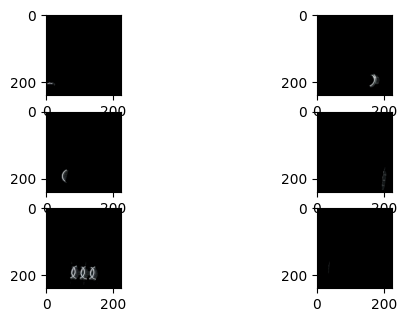

In [179]:
# Apply extracted regions as masks to original image (above_plate)
#  in order to obtain regions of interest (roi)
def extract_rois(img, regions):
    rois = []
    for r in regions:
        roi = img.copy()
        roi[r == 0] = (0,0,0)
        rois.append(roi)

    return rois

rois = extract_rois(above_plate, regions)

for (i, r) in enumerate(rois):
    plt.subplot(4, len(regions)//4 +1, i+1)
    print(entropy(r))
    show_converted(r)

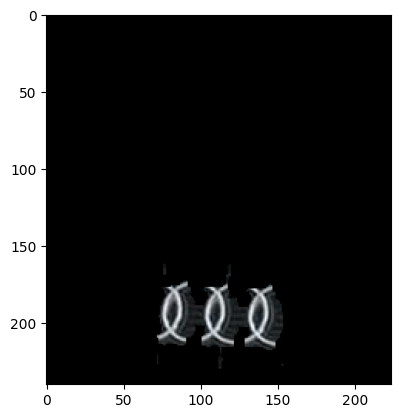

In [180]:
# The logo will have the greatest entropy
def color_entropy(img):
    hist, _bin = np.histogram(img.ravel(), 256, [0,255])
    entropy = 0.
    for i in hist[hist != 0]:
        p = i/img.size
        entropy -= p * np.log(p)
    return entropy

logo, logo_contour = sorted(zip(rois, filtered_contours), key=lambda x: color_entropy(x[0]), reverse=True)[0]

show_converted(logo)

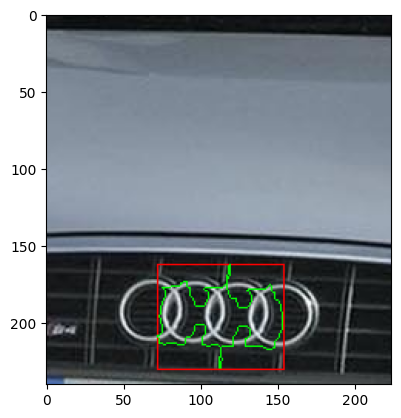

In [181]:
# Draw rectangle around logo contour
def show_logo(img, contour):
    rectangled_logo = img.copy()
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(rectangled_logo, (x, y), (x+w, y+h), (0, 0, 255), 1)
    cv2.drawContours(rectangled_logo, [contour], 0, (0, 255, 0), 1)
    show_converted(rectangled_logo)

show_logo(above_plate, logo_contour)

### All-in-one block

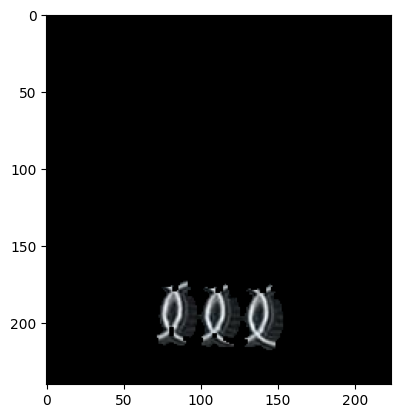

In [182]:
def extract_logo(img, plate_coor):
    # Retrieve probable area
    above_plate = crop_logo_zone(img, plate_coor).copy()
    above_gray = cv2.cvtColor(above_plate, cv2.COLOR_BGR2GRAY)
    # Calculate edges
    grad_x, grad_y = calculate_gradients(above_gray)
    h_maps = saliency(grad_x)
    v_maps = saliency(grad_y)
    Sh = np.max(h_maps, axis=0).astype("float32")
    Sv = np.max(v_maps, axis=0).astype("float32")
    h_binary = binary_kmeans(grad_x, Sh)
    v_binary = binary_kmeans(grad_y, Sv)
    d = 3
    h_closed = morph_close(h_binary, d)
    v_closed = morph_close(v_binary, d)
    # Calculate entropy
    h_entropy = entropy(h_closed)
    v_entropy = entropy(v_closed)
    clear_image = h_closed if h_entropy < v_entropy else v_closed
    # Extract separate rois
    contoured = clear_image.astype("uint8")
    contours, _ = cv2.findContours(contoured, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    filtered_contours = list(filter(lambda c: cv2.contourArea(c) > 20, contours))
    regions = extract_contours(clear_image, filtered_contours)
    rois = extract_rois(above_plate, regions)
    # Find most probable logo region
    logo, logo_contour = sorted(zip(rois, filtered_contours), key=lambda x: color_entropy(x[0]), reverse=True)[0]
    return logo

logo = extract_logo(blurred, coor)
show_converted(logo)

## Prediction of car model using pre-trained network

In [183]:
# Load model with default weights
def initialize_model(num_classes):
    weights = models.ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)

    # set_parameter_requires_grad
    for param in model.parameters():
        param.requires_grad = False

    fc_in_feats = model.fc.in_features
    model.fc = nn.Linear(fc_in_feats, num_classes)  # requires_grad=True by default

    model = model.to(DEVICE)

    return model, weights


# Predict top-k of car model
def predict(img, k=5):
    # The ResNet50 model trained on Stanford dataset
    img_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    df = pd.read_pickle("preprocessed_data.pkl")
    num_classes = df["Classname"].nunique()
    model, _ = initialize_model(num_classes)

    img = Image.fromarray(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
    if img.mode != "RGB":  # Convert png to jpg
        img = img.convert("RGB")
    img = img_transforms(img)
    img = img.to(DEVICE)
    img = img.unsqueeze(0)  # Add batch dimension (because single image)

    # Load trained model weights from current directory
    model_name="resnet50_40epochs.pt"
    model.load_state_dict(torch.load(str(model_name), map_location=DEVICE))

    model.to(DEVICE)
    model.eval()

    pd.set_option('display.max_rows', None)

    with torch.no_grad():
        output = model(img)
        _, preds = torch.topk(output, k)

    preds = torch.transpose(preds, 0, 1)
    preds = preds.cpu()  # Send tensor to cpu
    preds = pd.DataFrame(preds.numpy(), columns=["Classencoded"])  # Convert to dataframe

    class_encoded_matches = pd.merge(df, preds, how="inner")
    class_encoded_matches = pd.merge(preds, class_encoded_matches, how="left", on="Classencoded", sort=False)  # Preserves ordering
    classname_matches = class_encoded_matches["Classname"].unique()

    return classname_matches


Audi S4 Sedan 2007
Audi RS 4 Convertible 2008
Audi A4 2005
Audi A5 Coupe 2012
Audi A4 2007


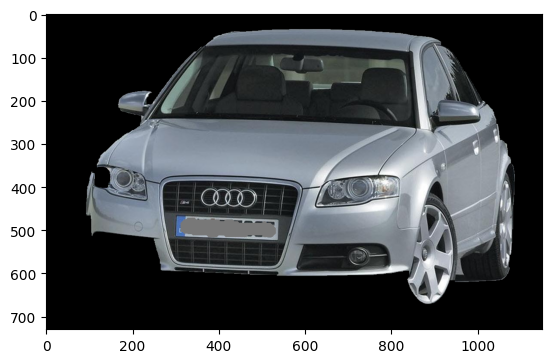

In [184]:
classname_matches = predict(blurred_image, TOP_K)
for classname in classname_matches:
    print(classname)

# Show blurred image
show_converted(blurred_image)

Audi S4 Sedan 2007
Audi S6 Sedan 2011
Audi A4 2007
Audi TT Hatchback 2011
Audi RS 4 Convertible 2008


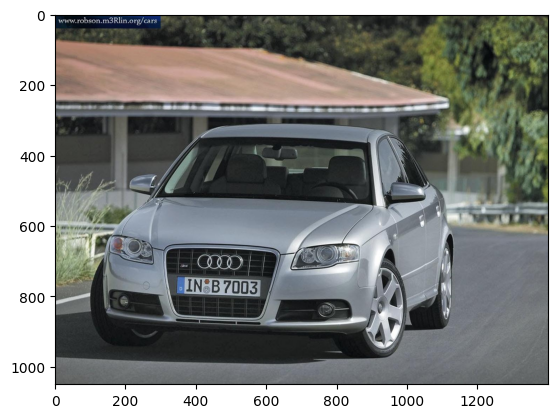

In [185]:
original_image = cv2.imread(IMAGE_PATH)
predictions = predict(original_image, TOP_K)
for pred in predictions:
    print(pred)

show_converted(original_image)

# All phases together


0: 480x640 1 car, 1 truck, 167.2ms
Speed: 6.6ms preprocess, 167.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 84.0
Res = [312 472 224  48] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'INB7003'


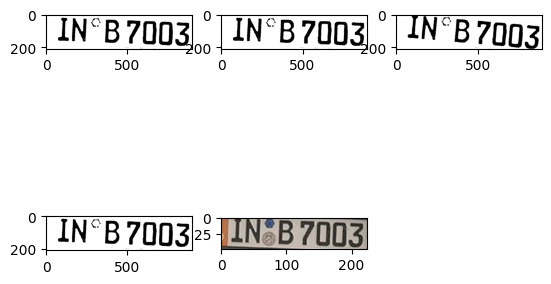

In [186]:
def all_phases(img_path):
    try:
        image = cv2.imread(img_path)
        if image is None:
            raise Exception("Image not found")
    except:
        print("Image not found")
        return 
    
    # Create folder with results
    only_name = Path(img_path).stem
    output_path = OUTPUT_DIR + only_name + "/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Enhance original image
    super_image = image.copy()
    cv2.imwrite(output_path + "superres.jpg", super_image)
    # Detection and segmentation
    segments, coordinates = all_segmentation(super_image)
    print(f"There are {len(segments)} vehicles")
    # Save segments
    for i in range(len(segments)):
        cv2.imwrite(output_path + "segment-" + str(i) + ".jpg", segments[i])

    # Try to extract plate information for each detected car
    names = []
    if len(segments) > 0:
        for i in range(len(segments)):
            text = ""
            segment = segments[i]
            try:
                blurred, coor, plate, text = plate_extraction(segment)
                cv2.imwrite(output_path + "blur-" + str(i) + ".jpg", blurred)

                logo = extract_logo(blurred, coor)
                # Save plate and logo
                cv2.imwrite(output_path + "plate-" + str(i) + ".jpg", plate)
                cv2.imwrite(output_path + "logo-" + str(i) + ".jpg", logo)
            except Exception as e:
                blurred = segment.copy()
                print(f"Couldn't find plate: {e}")
            
            # Predict car model
            classname_matches = predict(super_image, TOP_K)
            names.append((classname_matches[0], text))

        blurred_image = car_text(super_image, coordinates, [x[0] for x in names])
        cv2.imwrite(output_path + "labeled.jpg", blurred_image)
    else:
        # In case can't do anything
        blurred_image = super_image.copy()
    
    return (blurred_image, names)

_ = all_phases(IMAGE_PATH)


0: 480x640 1 car, 1 truck, 199.7ms
Speed: 6.2ms preprocess, 199.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 85.0
Res = [312 472 224  48] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'INB7003'


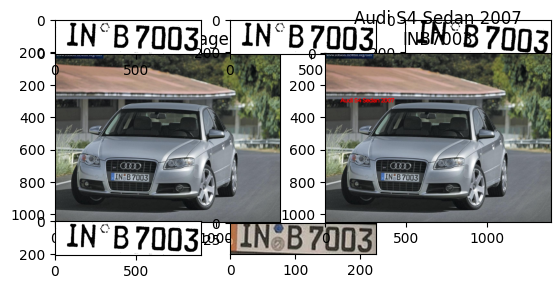

In [187]:
original_image = cv2.imread(IMAGE_PATH)
plt.subplot(1, 2, 1)
plt.title("Original image")
show_converted(original_image)

im, labels = all_phases(IMAGE_PATH)
plt.subplot(1, 2, 2)
plt.title(labels[0][0] + "\n" + labels[0][1])
show_converted(im)

--------------------------------

00020.jpg



0: 480x640 1 car, 164.1ms
Speed: 3.4ms preprocess, 164.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 110.0
Res = [112 266  88  18] with 2 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'MRE3992'
All took 15.829961061477661 seconds
BMW X5 SUV 2007
BMW X6 SUV 2012
BMW X3 SUV 2012
Bmw X5 2004
Hyundai Santa Fe SUV 2012
--------------------------------

00026.jpg



0: 480x640 1 car, 288.4ms
Speed: 10.5ms preprocess, 288.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 78.0
Res = [134 306 142  40] with 2 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'T8121KT'
All took 14.807193994522095 seconds
Volkswagen Golf Hatchback 1991
Ford Mustang 1966
Volkswagen Jetta 1999
Ford Mustang 2006
Ford Mustang 1990
--------------------------------

00103.jpg



0: 448x640 1 car, 174.0ms
Speed: 3.7ms preprocess, 174.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


There are 1 vehicles
Threshold was set to 71.0
Res = [584 316 304 132] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is ''
All took 29.741552114486694 seconds
BMW M3 Coupe 2012
BMW 1 Series Coupe 2012
BMW M5 Sedan 2010
BMW X6 SUV 2012
BMW 3 Series Wagon 2012
--------------------------------

00433.jpg



0: 352x640 1 car, 145.0ms
Speed: 3.7ms preprocess, 145.0ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)


There are 1 vehicles
Threshold was set to 74.0
Res = [328 138  84  32] with 2 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'INA6SUOTI'
All took 14.262598991394043 seconds
Audi S6 Sedan 2011
Audi RS 4 Convertible 2008
Audi S4 Sedan 2007
Rolls-Royce Ghost Sedan 2012
Audi TTS Coupe 2012
--------------------------------

00437.jpg



0: 448x640 1 bus, 1 truck, 162.9ms
Speed: 3.9ms preprocess, 162.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


There are 1 vehicles
Threshold was set to 58.0
Res = [155  86  50  18] with 1 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'ATS
3'
All took 12.84109091758728 seconds
Audi S4 Sedan 2012
Audi RS 4 Convertible 2008
Audi TT Hatchback 2011
Audi S5 Convertible 2012
Audi S6 Sedan 2011
--------------------------------

00523.jpg



0: 512x640 1 car, 184.4ms
Speed: 4.6ms preprocess, 184.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


There are 1 vehicles
Threshold was set to 85.0
Res = [136 292 108  44] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'NL765'
All took 15.710047721862793 seconds
Volvo C30 Hatchback 2012
Audi TT Hatchback 2011
Jaguar XK XKR 2012
Porsche Panamera Sedan 2012
Mercedes-Benz E-Class Sedan 2012
--------------------------------

00561.jpg



0: 448x640 1 car, 186.9ms
Speed: 2.8ms preprocess, 186.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


There are 1 vehicles
Threshold was set to 93.0
Res = [262 184 112  52] with 2 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'Y 1'
All took 14.034191846847534 seconds
Suzuki SX4 Sedan 2012
Suzuki Aerio Sedan 2007
Mazda Protege 2002
Honda Odyssey 2004
Nissan Altima 2005
--------------------------------

00585.jpg



0: 416x640 1 car, 1 truck, 149.3ms
Speed: 4.1ms preprocess, 149.3ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)


There are 1 vehicles
Threshold was set to 95.0
Res = [336 344 344  88] with 8 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'INERS443'
All took 31.50083041191101 seconds
Audi RS 4 Convertible 2008
BMW 1 Series Coupe 2012
Audi A4 2004
Mini Cooper 2008
Chrysler Crossfire Convertible 2008
--------------------------------

00652.jpg



0: 480x640 1 car, 1 truck, 172.0ms
Speed: 4.2ms preprocess, 172.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 84.0
Res = [312 472 224  48] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'INB7003'
All took 22.94136071205139 seconds
Audi S4 Sedan 2007
Audi S6 Sedan 2011
Audi A4 2007
Audi TT Hatchback 2011
Audi RS 4 Convertible 2008
--------------------------------

00929.jpg



0: 480x640 1 person, 1 car, 166.2ms
Speed: 3.8ms preprocess, 166.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 47.0
Res = [408 444 276  92] with 4 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'REGG75'
All took 24.836018562316895 seconds
Audi R8 Coupe 2012
Cadillac Cts 2006
Audi TT RS Coupe 2012
Audi RS 4 Convertible 2008
Chevrolet Cruze 2012
--------------------------------

01012.jpg



0: 480x640 1 car, 182.5ms
Speed: 3.4ms preprocess, 182.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


There are 1 vehicles
Threshold was set to 131.0
Res = [ 82 110  72  24] with 1 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'JOTS447'
All took 12.824395656585693 seconds
Audi 100 Sedan 1994
Ford Mustang 1990
Toyota Camry 2000
Audi 100 Wagon 1994
Ford Mustang 2000
--------------------------------

01377.jpg



0: 416x640 2 persons, 4 cars, 1 truck, 143.8ms
Speed: 4.0ms preprocess, 143.8ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


There are 5 vehicles
Threshold was set to 137.0
Couldn't find plate: list index out of range
Threshold was set to 93.0
Couldn't find plate: list index out of range
Threshold was set to 86.0
Res = [122 234 110  40] with 2 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is ''
Threshold was set to 72.0
Couldn't find plate: list index out of range
Threshold was set to 148.0
Res = [42 95 67 26] with 1 times
Saved as output/Super Resolution.jpg
Auto-computed angle is 0
Most probable text is 'O'
All took 27.282384872436523 seconds
Volkswagen Golf Hatchback 1991
Bentley Arnage Sedan 2009
Bentley Continental Flying Spur Sedan 2007
FIAT 500 Abarth 2012
Volkswagen Passat 2006


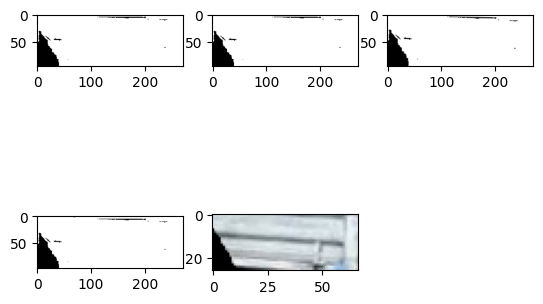

In [188]:
# Execute on all dataset
DATASET_PATH = "img/Dataset/"
for(file) in sorted(os.listdir(DATASET_PATH))[0:]:
    print("--------------------------------\n")
    print(file)
    start = time.time()
    img, names = all_phases(DATASET_PATH + file)
    with open(OUTPUT_DIR + "names.csv", "+a") as f:
        labels = [x[0] + "," + x[1].replace(" ", "").replace("\n","") for x in names]
        f.write(file + "," + ",".join(labels) + "\n")
    print(f"All took {time.time() - start} seconds")

    original_image = cv2.imread(DATASET_PATH + file)
    predictions = predict(original_image, TOP_K)
    for pred in predictions:
        print(pred)
    